# Variación de Propiedades Nucleares: Modelo de Materia de Estrellas de Neutrones

In [1]:
# Importamos las librerías necesarias
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
import sys
import pathlib
scripts_path = pathlib.Path().cwd() / 'scripts'  # Aseguramos que el directorio de scripts esté en el path
sys.path.append(str(scripts_path))
# Importamos nuestros módulos
import scripts.ResolverTOV as tov
import scripts.NSMatterEoS as nsEoS
from scripts.NSMatterEoS import m_nuc_MKS, m_nuc, MeVfm_to_Jm, MeV_to_fm11
from scripts.Optimizar_IsospinEoS import (
    optimizar_parametros, 
    crear_propiedades_objetivo,
    estudiar_parametros_vs_propiedades,
    plot_convergencia_optimizacion,
    plot_parametros_vs_propiedad,
    calcular_masa_radio_optimizado,
    plot_masa_radio_para_variaciones
)

## 1. Optimización de Parámetros del Modelo $\sigma^4$-$\omega$-$\mathbf{\rho}$

Primero, vamos a optimizar los parámetros del modelo para ajustar las propiedades de saturación nuclear.

In [ ]:
# Crear propiedades objetivo con valores experimentales
props_experimentales = crear_propiedades_objetivo(
    n_sat=0.161,    # fm^-3
    B_A_sat=-16.24, # MeV  
    K_mod=230.0,    # MeV
    a_sym=31.6      # MeV
    L=58.9,      # MeV
)

# Optimizar parámetros usando el método de mínimos cuadrados
resultados_ls = optimizar_parametros(
    props_experimentales,
    metodo='leastsq',
    verbose=True
)

Iniciando optimización con método: leastsq
Parámetros iniciales:
  A_sigma: 287.1702
  A_omega: 161.8332
  A_rho: 99.8439
  b: 0.0056
  c: -0.0070

No se encontró solución para n_barion =  0.176796941424003
No se encontró solución para n_barion =  0.1873817422860383
No se encontró solución para n_barion =  0.19860025325859118
No se encontró solución para n_barion =  0.21049041445120198
No se encontró solución para n_barion =  0.22309243744089835
No se encontró solución para n_barion =  0.23644894126454072
No se encontró solución para n_barion =  0.250605096553008
No se encontró solución para n_barion =  0.26560877829466867
No se encontró solución para n_barion =  0.281510727744773
No se encontró solución para n_barion =  0.298364724028334
No se encontró solución para n_barion =  0.31622776601683794
Optimización completada!
Éxito: True
Chi² final: 0.044910

Parámetros optimizados:
  A_sigma: 296.483814
  A_omega: 168.193497
  A_rho: 66.736231
  b: 0.005533
  c: -0.006918

Comparación de

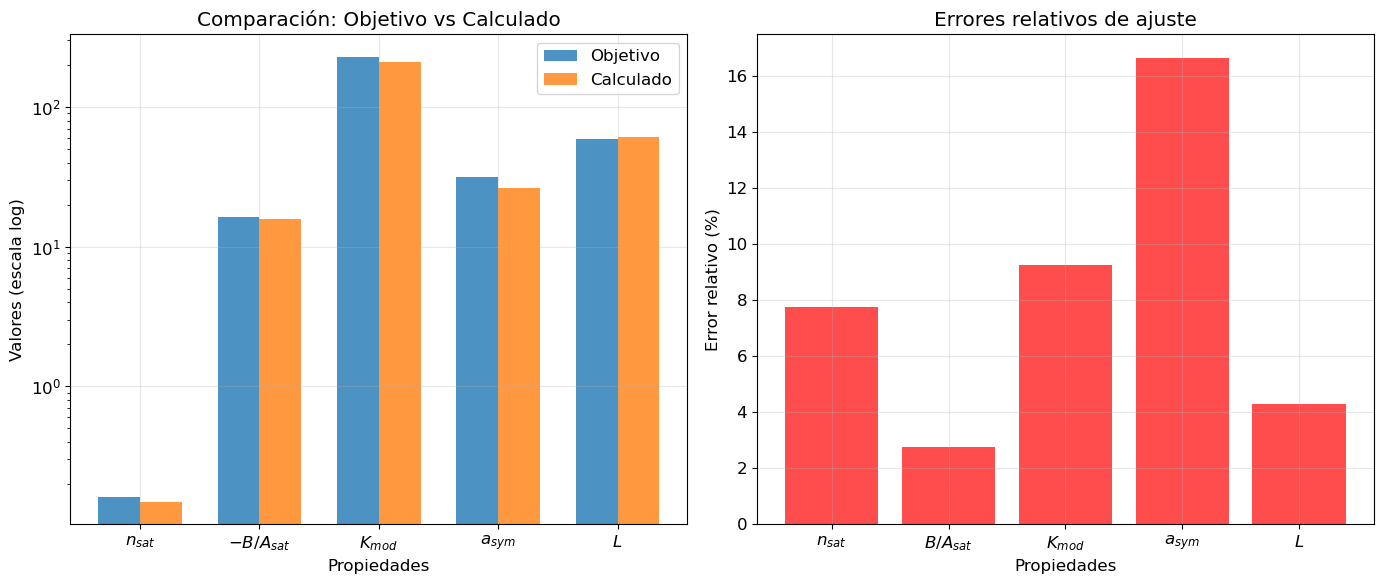

In [3]:
# Visualizar los resultados de la optimización
plot_convergencia_optimizacion(resultados_ls)

## 2. Comparación de Métodos de Optimización

Vamos a comparar diferentes métodos de optimización para ver cuál funciona mejor.

In [4]:
# Probar diferentes métodos de optimización
metodos = ['leastsq', 'least_squares', 'nelder', 'differential_evolution']
resultados_metodos = {}

for metodo in metodos:
    print(f"\n=== OPTIMIZACIÓN CON {metodo.upper()} ===")

    if metodo == 'differential_evolution':
        # Para differential evolution, podemos especificar más opciones para no demorar tanto
        resultado = optimizar_parametros(
            props_experimentales,
            metodo=metodo,
            max_nfev=1000,  # Máximo número de iteraciones
            popsize=15,   # Tamaño de población
            verbose=False
        )
    else:
        # Para otros métodos de lmfit usamos configuración por defecto
        resultado = optimizar_parametros(
            props_experimentales,
            metodo=metodo,
            verbose=False
        )

    resultados_metodos[metodo] = resultado


=== OPTIMIZACIÓN CON LEASTSQ ===

=== OPTIMIZACIÓN CON LEAST_SQUARES ===

=== OPTIMIZACIÓN CON NELDER ===

=== OPTIMIZACIÓN CON DIFFERENTIAL_EVOLUTION ===


In [5]:
# Comparar los resultados de los diferentes métodos
print("\n=== COMPARACIÓN DE MÉTODOS ===")
print(f"{'Método':<22} {'Chi²':<12} {'Éxito':<8} {'n_sat error (%)':<15}")
print("-" * 60)

for metodo, resultado in resultados_metodos.items():
    if resultado['propiedades_calculadas']:
        chi2 = resultado['chi2_final']
        exito = "Sí" if resultado['exito'] else "No"
        
        # Calcular error en n_sat como ejemplo
        n_sat_obj = resultado['propiedades_objetivo']['n_sat']
        n_sat_calc = resultado['propiedades_calculadas']['n_sat']
        error_nsat = 100 * abs(n_sat_calc - n_sat_obj) / n_sat_obj
        
        print(f"{metodo:<22} {chi2:<12.6f} {exito:<8} {error_nsat:<15.2f}")
    else:
        print(f"{metodo:<22} {'FALLÓ':<12} {'No':<8} {'-':<15}")


=== COMPARACIÓN DE MÉTODOS ===
Método                 Chi²         Éxito    n_sat error (%)
------------------------------------------------------------
leastsq                0.001007     Sí       2.24           
least_squares          0.011034     Sí       2.24           
nelder                 0.001007     Sí       2.24           
differential_evolution 7.958535     No       99.38          


## 3. Dependencia de Parámetros con Propiedades de Saturación

Ahora estudiaremos cómo cambian los parámetros optimizados cuando variamos cada una de las propiedades de saturación.

In [6]:
# Definir rangos de variación para cada propiedad
variaciones = {
    'n_sat': np.linspace(0.14, 0.18, 8),     # Densidad de saturación
    'B_A_sat': np.linspace(-18, -14, 8),     # Energía de enlace 
    'K_mod': np.linspace(200, 260, 8),       # Módulo de compresión
    'a_sym': np.linspace(29, 35, 8)          # Coeficiente de simetría
}

# Realizar estudio paramétrico
print("Iniciando estudio paramétrico...")
print("(Esto puede tomar varios minutos dependiendo de los rangos)")

resultados_estudio = estudiar_parametros_vs_propiedades(
    props_experimentales,
    variaciones,
    metodo='leastsq'  # Usamos el método más eficiente
)

print("\nEstudio paramétrico completado!")

Iniciando estudio paramétrico...
(Esto puede tomar varios minutos dependiendo de los rangos)

Estudiando variación de n_sat...

Estudiando variación de B_A_sat...

Estudiando variación de K_mod...

Estudiando variación de a_sym...

Estudio paramétrico completado!



Graficando variación de parámetros vs n_sat


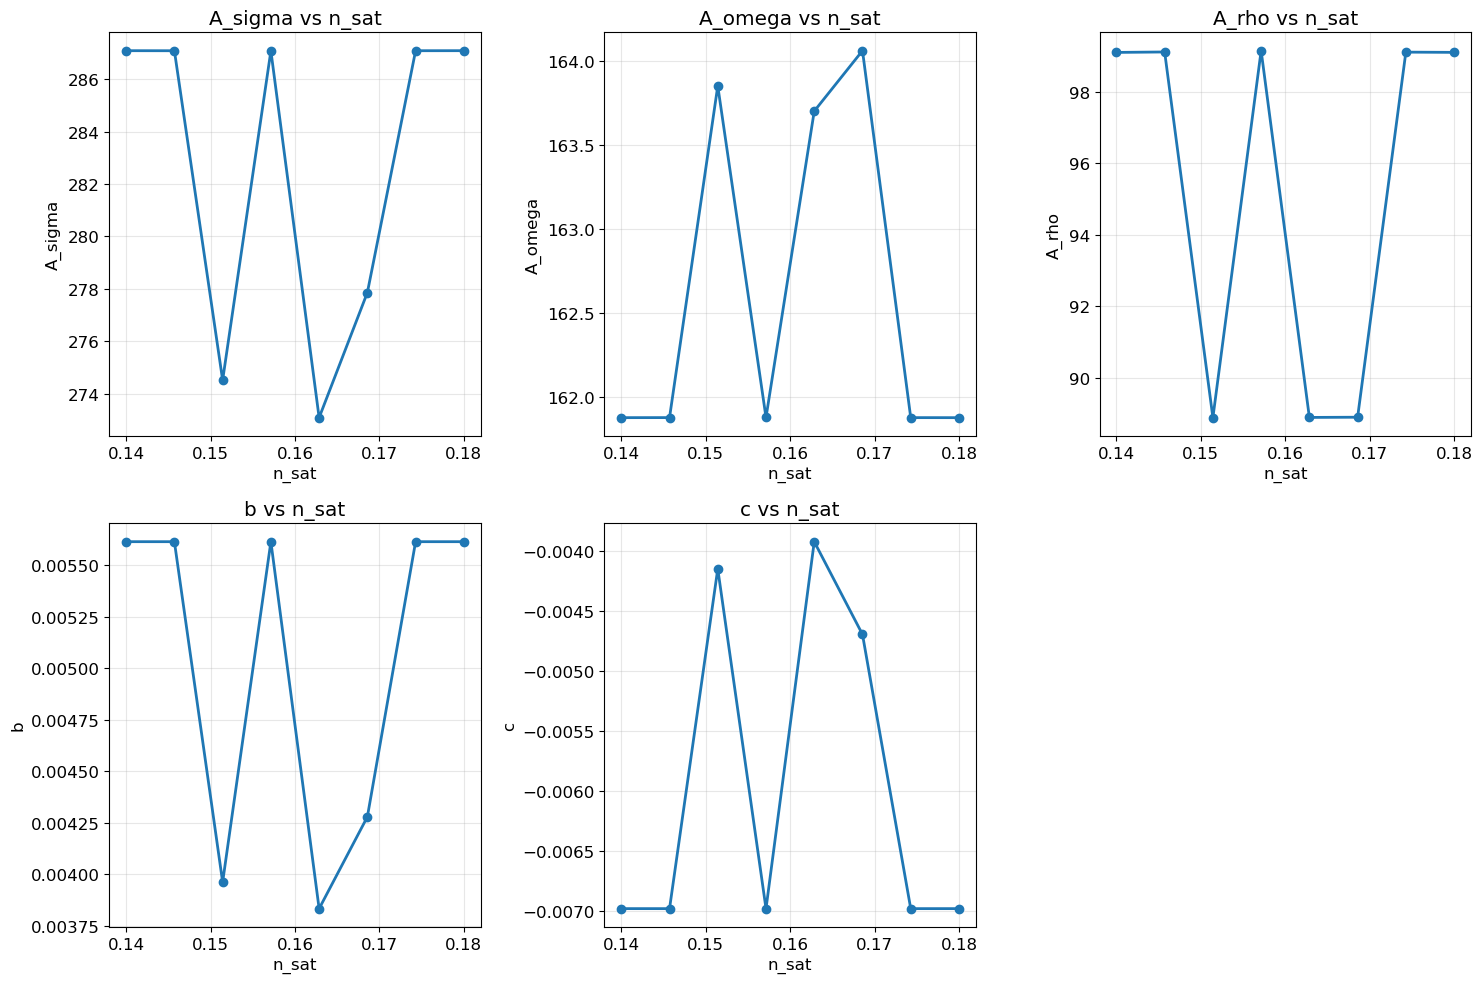


Graficando variación de parámetros vs B_A_sat


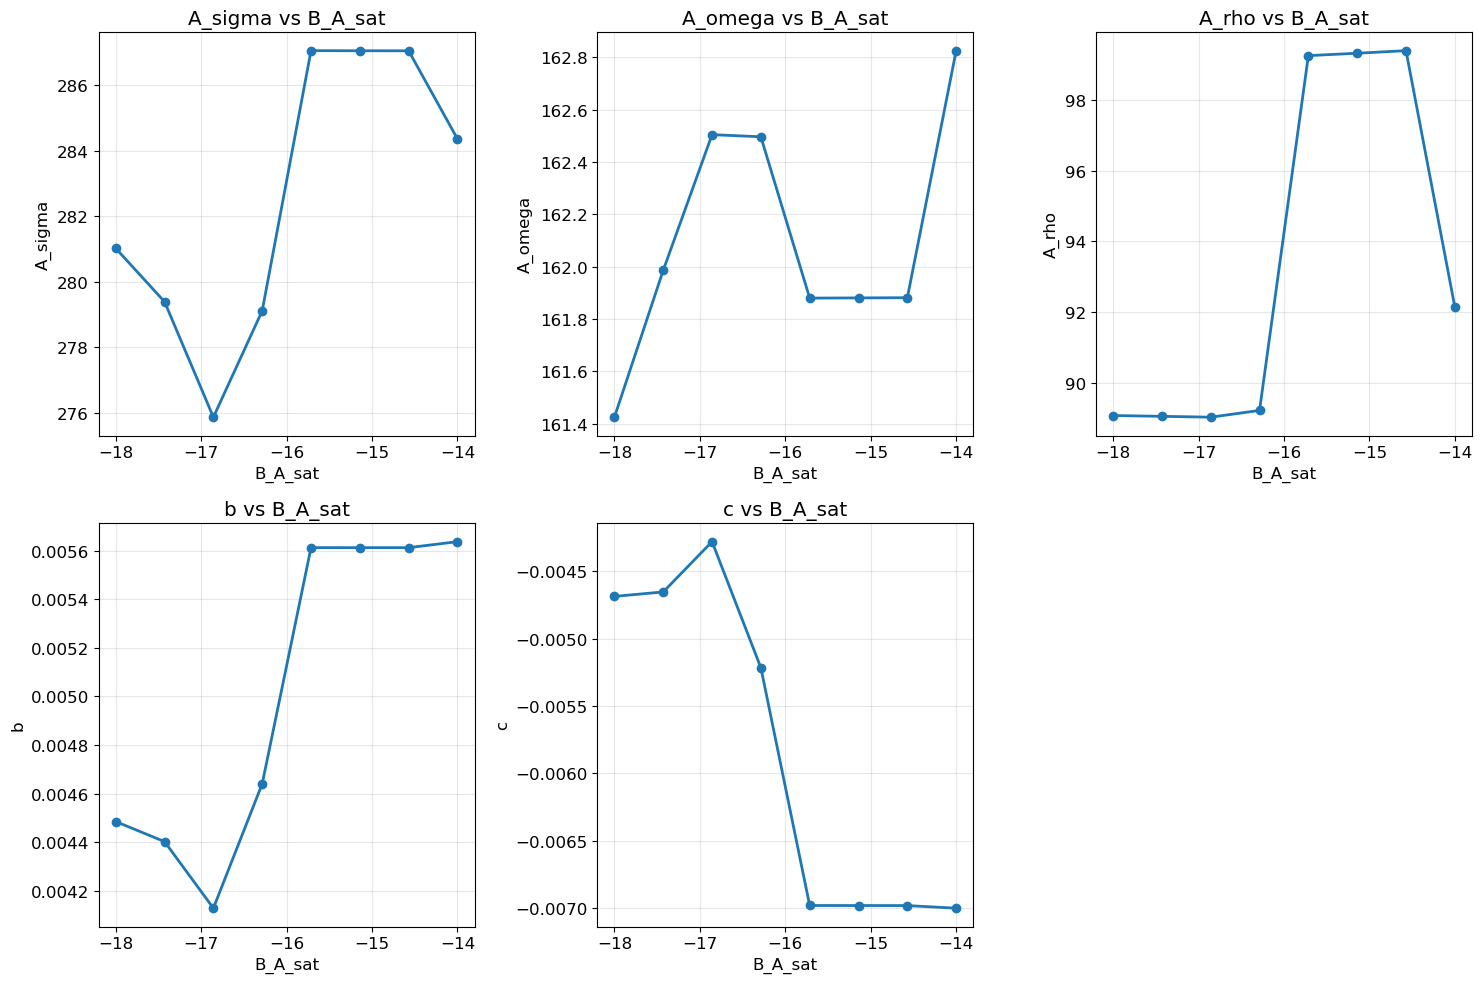


Graficando variación de parámetros vs K_mod


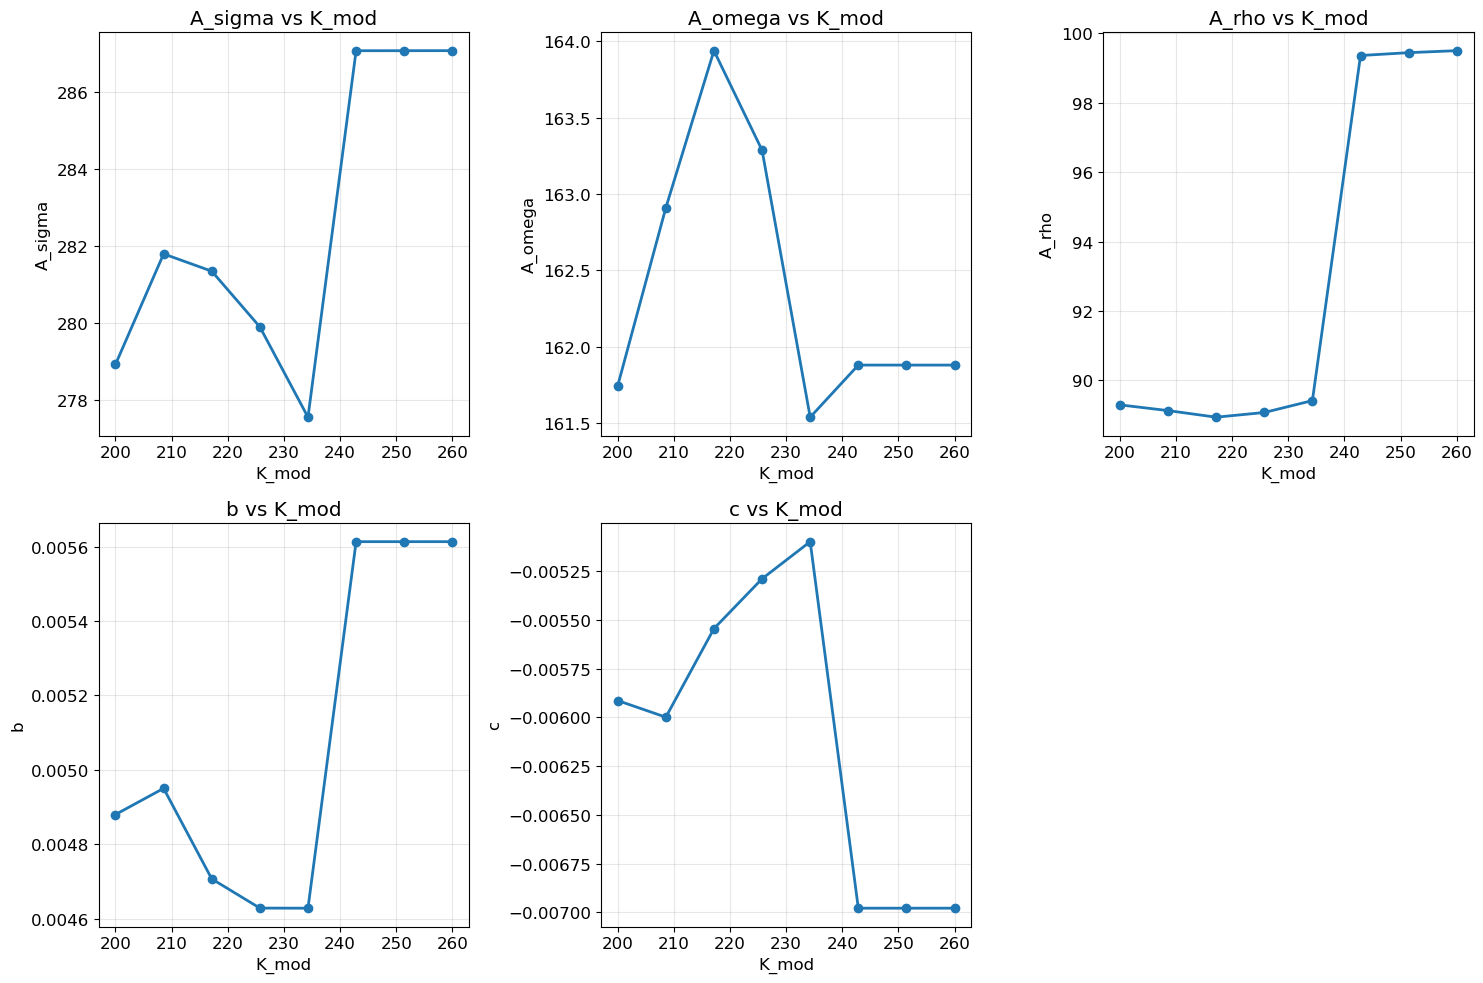


Graficando variación de parámetros vs a_sym


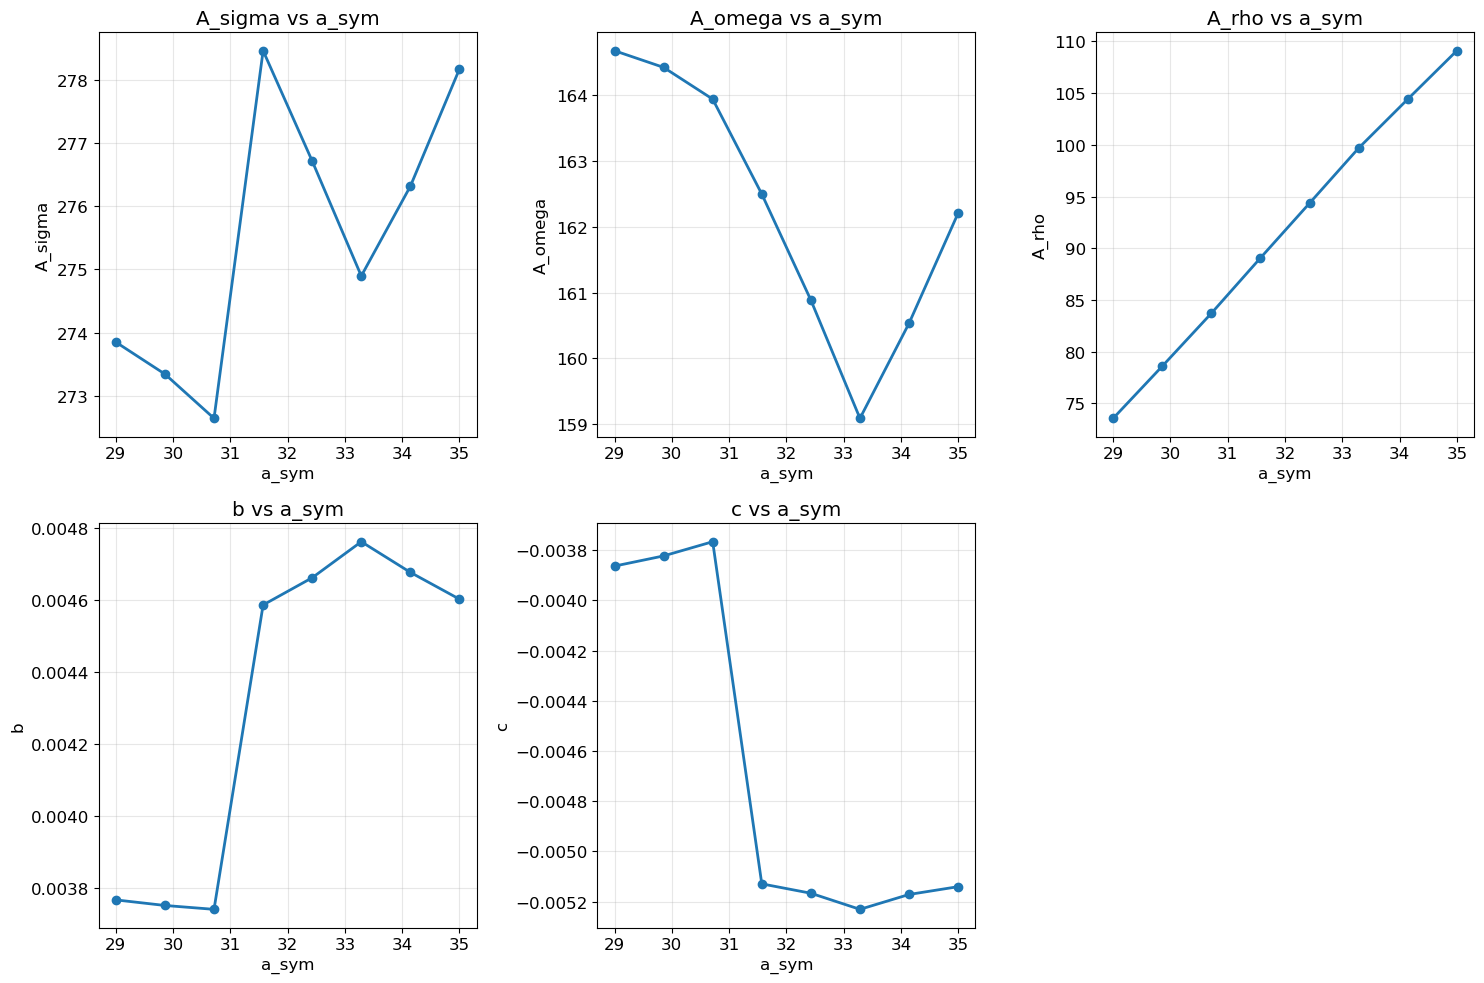

In [7]:
# Visualizar cómo varían los parámetros con cada propiedad
for propiedad in variaciones.keys():
    print(f"\nGraficando variación de parámetros vs {propiedad}")
    plot_parametros_vs_propiedad(resultados_estudio, propiedad)

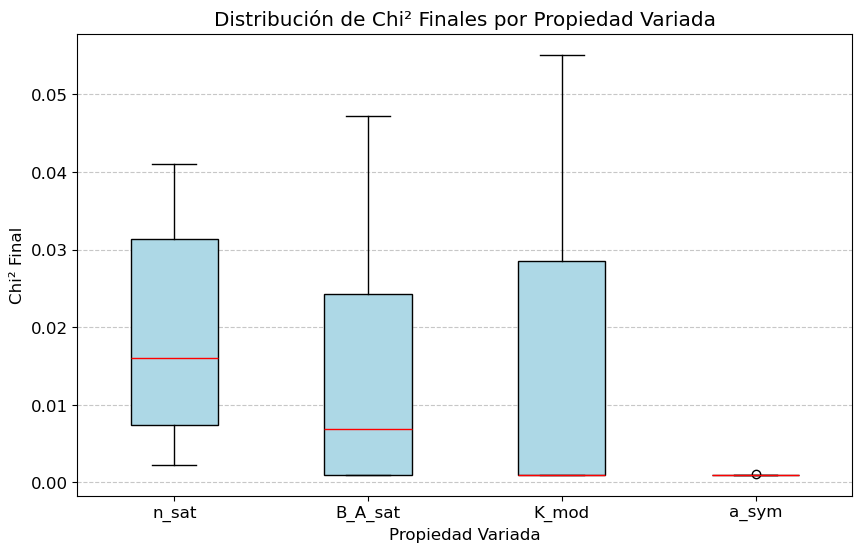

In [10]:
# Boxplot de la distribución de Chi² finales por propiedad variada
chi2_por_prop = [
    [res['chi2'] for res in resultados]
    for resultados in resultados_estudio.values()
]
labels = list(resultados_estudio.keys())

plt.figure(figsize=(10, 6))
plt.boxplot(
    chi2_por_prop,
    tick_labels=labels,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black'),
    medianprops=dict(color='red')
)
plt.title('Distribución de Chi² Finales por Propiedad Variada')
plt.xlabel('Propiedad Variada')
plt.ylabel('Chi² Final')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4. Estudio Masa-Radio para Diferentes Propiedades

Finalmente, vamos a estudiar cómo afectan las variaciones en las propiedades de saturación a la relación masa-radio de las estrellas de neutrones.

Parámetros optimizados: [np.float64(313.6313668800485), np.float64(180.15693033055356), np.float64(65.11357416754605), np.float64(0.005334256256663816), np.float64(-0.006938324943949071)]
Propiedades calculadas: {'n_sat': np.float64(0.14010855255980173), 'B_A_sat': np.float64(-15.390017997184772), 'K_mod': np.float64(191.37005832701072), 'a_sym': np.float64(24.929684353027554), 'L': np.float64(57.88363915823726)}


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\User

Parámetros optimizados: [np.float64(296.3847620879151), np.float64(168.14030465190447), np.float64(65.37757141009607), np.float64(0.005534316110872907), np.float64(-0.006918005146554433)]
Propiedades calculadas: {'n_sat': np.float64(0.1484968262254465), 'B_A_sat': np.float64(-15.78937866466243), 'K_mod': np.float64(208.72813338383773), 'a_sym': np.float64(26.11510397648426), 'L': np.float64(60.755695048069676)}
Parámetros optimizados: [np.float64(296.51965384036885), np.float64(168.2167818180733), np.float64(67.17518920322753), np.float64(0.005532767772298705), np.float64(-0.006918202720926638)]
Propiedades calculadas: {'n_sat': np.float64(0.1484968262254465), 'B_A_sat': np.float64(-15.796443890702209), 'K_mod': np.float64(208.6908424493994), 'a_sym': np.float64(26.408259494092636), 'L': np.float64(61.63190431210331)}
Parámetros optimizados: [np.float64(296.6562568339143), np.float64(168.30589516702247), np.float64(68.6704682328792), np.float64(0.005530770863015873), np.float64(-0.0069

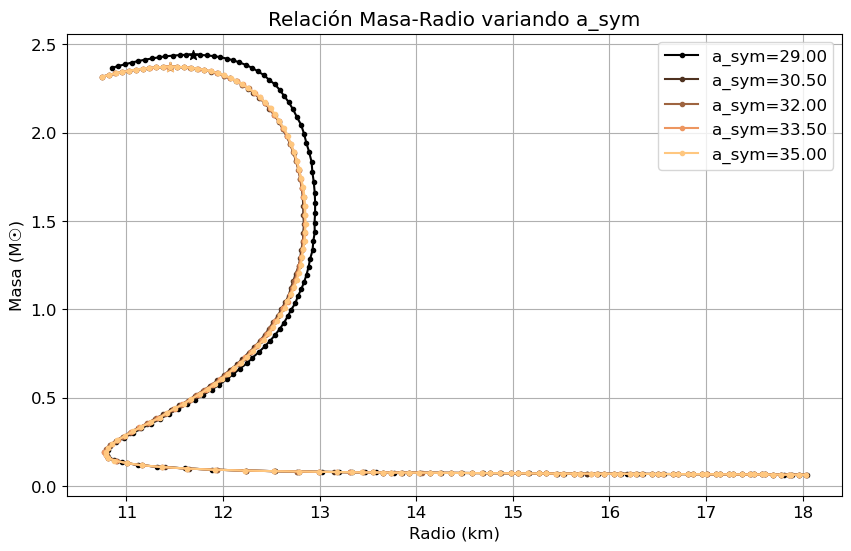

In [4]:
# Estudio de masa-radio variando una propiedad especifica
propiedad_estudio = 'a_sym'
valores_prop = np.linspace(29, 35, 5)
plot_masa_radio_para_variaciones(props_experimentales, propiedad_estudio, valores_prop)


===== ESTUDIO PARA: N_SAT =====
  Calculando para n_sat = 0.140...


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


  Calculando para n_sat = 0.146...
  Calculando para n_sat = 0.151...
  Calculando para n_sat = 0.157...


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: invalid value encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)


  Calculando para n_sat = 0.163...
  Calculando para n_sat = 0.169...
  Calculando para n_sat = 0.174...
  Calculando para n_sat = 0.180...

===== ESTUDIO PARA: B_A_SAT =====
  Calculando para B_A_sat = -18.000...
  Calculando para B_A_sat = -17.429...
  Calculando para B_A_sat = -16.857...
  Calculando para B_A_sat = -16.286...
  Calculando para B_A_sat = -15.714...
  Calculando para B_A_sat = -15.143...
  Calculando para B_A_sat = -14.571...
  Calculando para B_A_sat = -14.000...

===== ESTUDIO PARA: K_MOD =====
  Calculando para K_mod = 200.000...
  Calculando para K_mod = 208.571...
  Calculando para K_mod = 217.143...
  Calculando para K_mod = 225.714...
  Calculando para K_mod = 234.286...
  Calculando para K_mod = 242.857...
  Calculando para K_mod = 251.429...
  Calculando para K_mod = 260.000...

===== ESTUDIO PARA: A_SYM =====
  Calculando para a_sym = 29.000...
  Calculando para a_sym = 29.857...
  Calculando para a_sym = 30.714...
  Calculando para a_sym = 31.571...
  Calcu

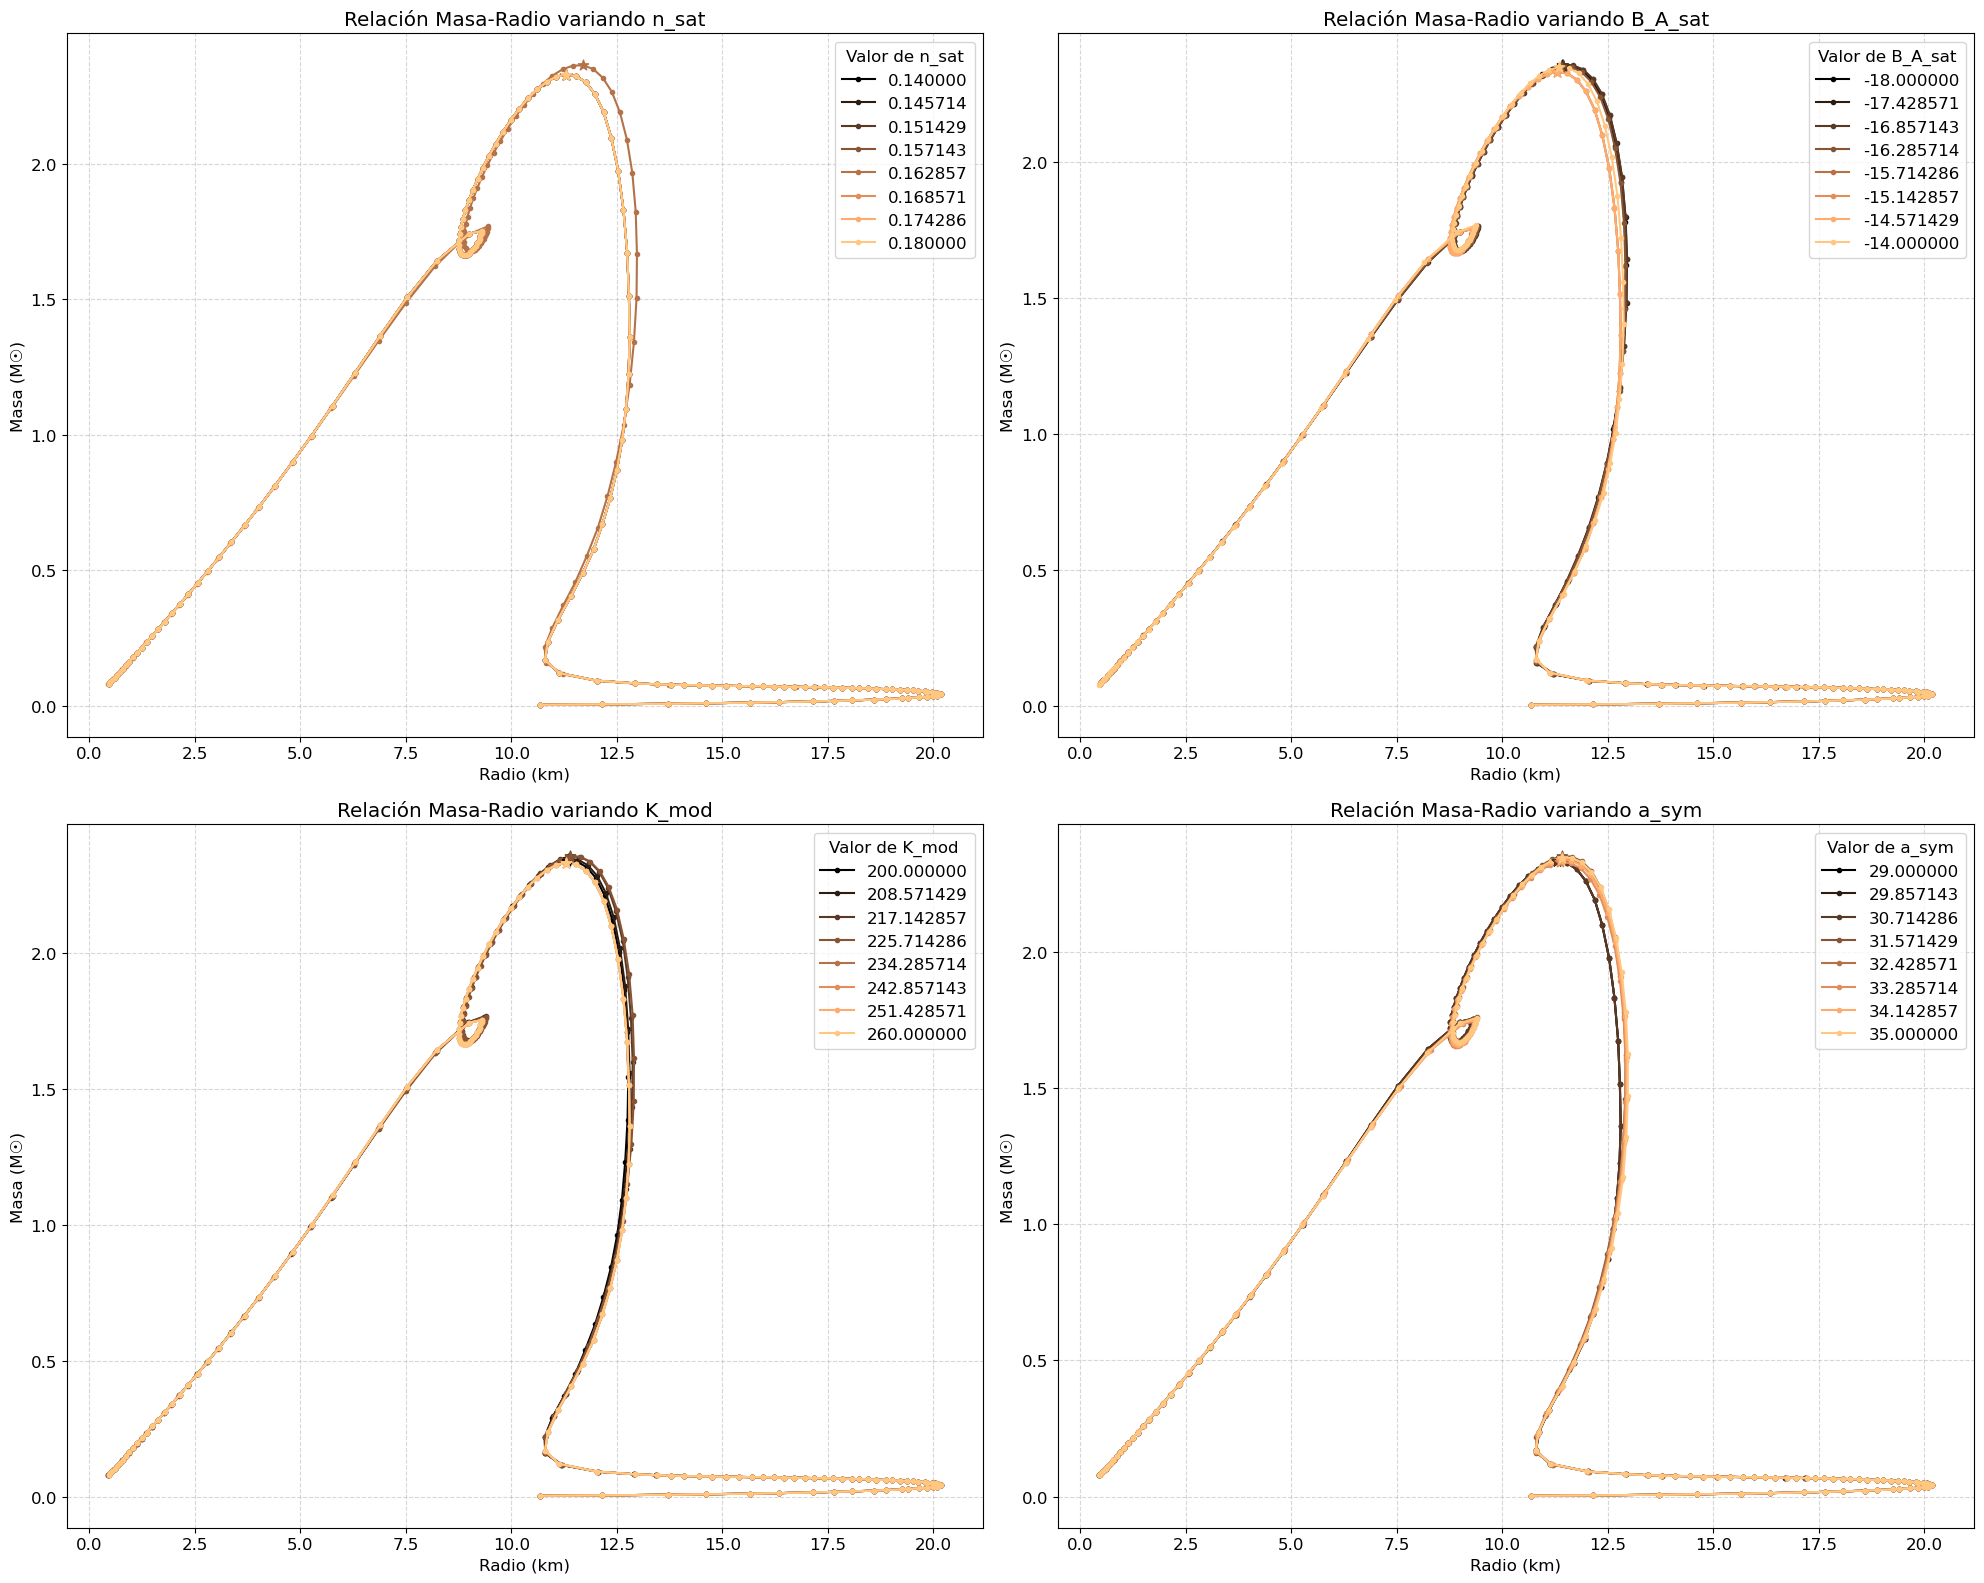

In [3]:
# Definir rangos de variación para cada propiedad
variaciones = {
    'n_sat': np.linspace(0.14, 0.18, 8),     # Densidad de saturación
    'B_A_sat': np.linspace(-18, -14, 8),     # Energía de enlace 
    'K_mod': np.linspace(200, 260, 8),       # Módulo de compresión
    'a_sym': np.linspace(29, 35, 8)          # Coeficiente de simetría
}

# Crear una figura con 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()  # Aplanar el array de ejes para iterar fácilmente

# Iterar sobre cada propiedad y su rango de variación
for idx, (propiedad, valores) in enumerate(variaciones.items()):
    ax = axes[idx]
    colores = plt.cm.copper(np.linspace(0, 1, len(valores)))
    
    print(f"\n===== ESTUDIO PARA: {propiedad.upper()} =====")
    
    # Iterar sobre cada valor de la propiedad
    for i, valor in enumerate(valores):
        print(f"  Calculando para {propiedad} = {valor:.3f}...")
        
        # Crear propiedades objetivo temporales
        props_temp = props_experimentales.copy()
        props_temp[propiedad] = valor
        
        # Calcular la relación masa-radio
        masas, radios, _ = calcular_masa_radio_optimizado(props_temp)
        
        if masas is not None and radios is not None:
            # Graficar la curva M-R
            ax.plot(radios, masas, "o-", color=colores[i], linewidth=1.5, markersize=3, 
                    label=f'{valor:3f}')
            
            # Marcar la masa máxima
            masa_max_idx = np.argmax(masas)
            ax.scatter(radios[masa_max_idx], masas[masa_max_idx], 
                       color=colores[i], s=60, marker='*', zorder=5)
        else:
            print(f"    Cálculo fallido para {propiedad} = {valor}")

    # Configurar el subplot
    ax.set_xlabel('Radio (km)')
    ax.set_ylabel('Masa (M☉)')
    ax.set_title(f'Relación Masa-Radio variando {propiedad}')
    ax.legend(title=f'Valor de {propiedad}')
    ax.grid(True, linestyle='--', alpha=0.5)

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()

## 5. Fijación de Parámetros

Vamos a fijar algunos parámetros del modelo para ver cómo afecta esto a las propiedades de saturación y a la relación masa-radio.

Parámetros optimizados: [np.float64(237.53670336992616), np.float64(131.3810724700402), np.float64(70.31991654413358), 0.00561, np.float64(-0.004831244296118379)]
Propiedades calculadas: {'n_sat': np.float64(0.1668100537200059), 'B_A_sat': np.float64(-16.239882520091616), 'K_mod': np.float64(229.99791939769085), 'a_sym': np.float64(28.999978052723524)}


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\User

Parámetros optimizados: [np.float64(272.60140987150857), np.float64(152.7742884768941), np.float64(84.64350879360809), 0.00561, np.float64(-0.006302836314198843)]
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.23991759359894), 'K_mod': np.float64(229.99856824740783), 'a_sym': np.float64(30.499978910426112)}
Parámetros optimizados: [np.float64(287.16222645981424), np.float64(161.8369350883461), np.float64(99.79750544939877), 0.00561, np.float64(-0.006985441343222887)]
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.28659322959558), 'K_mod': np.float64(217.29392794228258), 'a_sym': np.float64(33.376200625105845)}
Parámetros optimizados: [np.float64(287.1620573420529), np.float64(161.83693982420525), np.float64(99.8498511397241), 0.00561, np.float64(-0.006985460691952564)]
Propiedades calculadas: {'n_sat': np.float64(0.15738730431619027), 'B_A_sat': np.float64(-16.28655548499087), 'K_mod': np.float6

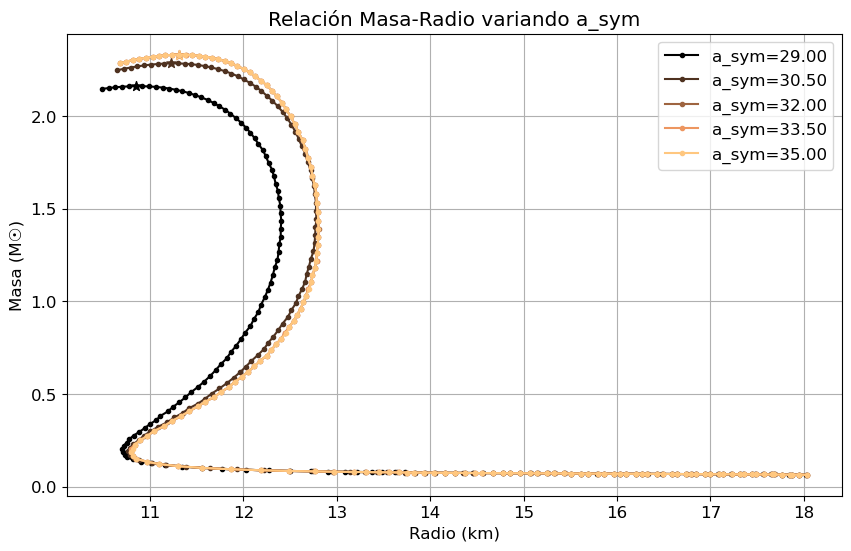

In [3]:
# Veamos que sucede cuando fiajmos b y variamos a_sym
param_fijado = 'b'
propiedad_estudio = 'a_sym'
valores_prop = np.linspace(29, 35, 5)

plot_masa_radio_para_variaciones(props_experimentales, propiedad_estudio, valores_prop, fixed_params=[param_fijado])